In [1]:
!python --version

Python 3.10.12


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0
True


In [3]:
!pip install -U transformers
!pip install -U datasets
!pip install tensorboard
!pip install sentencepiece
!pip install accelerate
!pip install evaluate
!pip install rouge_score
!pip install bert_score
!pip install bleu
!pip install -U scikit-learn


     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     --------- ------------------------------ 10.2/43.7 kB ? eta -:--:--
     ----------------------------------- -- 41.0/43.7 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 43.7/43.7 kB 355.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.5 MB 1.1 MB/s eta 0:00:09
   - -------------------------------------- 0.3/9.5 MB 3.0 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/9.5 MB 4.3 MB/s eta 0:00:03
   ------ --------------------------------- 1.5/9.5 MB 8.2 MB/s eta 0:00:01
   ---------------- ----------------------- 3.9/9.5 MB 16.7 MB/s eta 0:00:01
   ------------------------------------ --- 8.6/9.5 MB 30.5 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.3
 

In [4]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"]="1,3"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"

torch.cuda.empty_cache()

from evaluate import load

metric_bleu = load("bleu")
metric_bert = load("bertscore")

Using the latest cached version of the module from C:\Users\apare\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--bleu\9e0985c1200e367cce45605ce0ecb5ede079894e0f24f54613fca08eeb8aff76 (last modified on Wed May 29 23:24:47 2024) since it couldn't be found locally at evaluate-metric--bleu, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\apare\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--bertscore\cf4907b18f8f741f202232c0f8009a3bd49ff98802c245abcb6ea51a37a8c05b (last modified on Wed May 29 23:24:49 2024) since it couldn't be found locally at evaluate-metric--bertscore, or remotely on the Hugging Face Hub.


In [5]:
import json
lista_pictogramas_ids=[]
with open("ids_arasaac.txt", 'r', encoding='utf-8') as archivo:
  lineas = archivo.readlines()
  for linea in lineas:
    lista_pictogramas_ids.append(linea.strip())

print(len(lista_pictogramas_ids))

36887


In [6]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset

with open('dataset_basico.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

train_data, test_val_data = train_test_split(data, test_size=0.12, random_state=42)

test_data, validation_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

# Paso 4: Guardar los conjuntos divididos en archivos JSON separados
with open('train_data.json', 'w', encoding='utf-8') as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)

with open('test_data.json', 'w',  encoding='utf-8') as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

with open('validation_data.json', 'w',  encoding='utf-8') as validation_file:
    json.dump(validation_data, validation_file, ensure_ascii=False, indent=4)

print(f'Número de ejemplos en el conjunto de entrenamiento: {len(train_data)}')
print(f'Número de ejemplos en el conjunto de prueba: {len(test_data)}')
print(f'Número de ejemplos en el conjunto de validación: {len(validation_data)}')


dataset_train = load_dataset(
    'json',
    data_files='train_data.json',
    split='train'
)

dataset_test = load_dataset(
    'json',
    data_files='test_data.json',
    split='train'
)

dataset_valid = load_dataset(
    'json',
    data_files='validation_data.json',
    split='train'
)

Número de ejemplos en el conjunto de entrenamiento: 15437
Número de ejemplos en el conjunto de prueba: 1053
Número de ejemplos en el conjunto de validación: 1053


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_checkpoint = "flax-community/spanish-t5-small" #"vgaraujov/t5-base-spanish"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
print(model.device)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

tokenizer.add_tokens(lista_pictogramas_ids)
model.resize_token_embeddings(len(tokenizer))

print("new params")
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

cpu
60,493,824 total parameters.
60,493,824 training parameters.
new params
79,363,072 total parameters.
79,363,072 training parameters.


In [7]:
new_token_ids = tokenizer.convert_tokens_to_ids(lista_pictogramas_ids)

new_embeddings = model.get_input_embeddings().weight.data[new_token_ids]
print(new_embeddings)
lista_pictogramas_ids


tensor([[-1.0225, -1.3693,  0.1508,  ..., -0.6925,  0.4301, -0.4871],
        [ 0.6007, -0.1496, -0.3522,  ..., -0.0362, -0.2469, -0.6999],
        [ 0.6571,  0.8264, -0.4402,  ..., -0.3716, -1.1276, -1.2291],
        ...,
        [-0.8876,  0.1745, -1.2196,  ..., -0.8783, -1.3918,  1.3316],
        [-1.9886,  0.3576, -1.3507,  ...,  1.1862,  0.6844,  0.9938],
        [-0.8187, -1.3851,  1.4176,  ..., -0.4858, -0.5244, -1.0851]])


['#2247#acera#',
 '#2247#acera#plural#',
 '#2247#vereda#',
 '#2247#vereda#plural#',
 '#2248#agua#',
 '#2248#agua#plural#',
 '#2249#alfombra#',
 '#2249#alfombra#plural#',
 '#2250#almohada#',
 '#2250#almohada#plural#',
 '#2251#ambulancia#',
 '#2251#ambulancia#plural#',
 '#2252#anillo#',
 '#2252#anillo#plural#',
 '#2253#antena#',
 '#2253#antena#plural#',
 '#2253#parabólica#',
 '#2253#parabólica#plural#',
 '#2254#araña#',
 '#2254#araña#plural#',
 '#2255#amigos#',
 '#2256#árbol#',
 '#2256#árbol#plural#',
 '#2257#ardilla#',
 '#2257#ardilla#plural#',
 '#2258#armario#',
 '#2258#armario#plural#',
 '#2258#ropero#',
 '#2258#ropero#plural#',
 '#2259#arroz con tomate#',
 '#2259#arroz con tomate#plural#',
 '#2260#ascensor#',
 '#2260#ascensor#plural#',
 '#2261#asustado#',
 '#2261#asustado#plural#',
 '#2239#abeja#',
 '#2239#abeja#plural#',
 '#2242#abrigo#',
 '#2242#abrigo#plural#',
 '#2243#abuela#',
 '#2243#abuela#plural#',
 '#2243#yaya#',
 '#2243#yaya#plural#',
 '#2244#abuelo#',
 '#2244#abuelo#plural

In [8]:
model.to(torch.device('cuda'))
model.device

device(type='cuda', index=0)

In [10]:
max_input_length = 90
max_target_length = 90

batch_size=16

metric ="bleu"
#metric ="bert"

model_name = "t5-xgen-finetuned"
evaluation_strategy = "epoch"
save_strategy="epoch"
overwrite_output_dir=True
learning_rate=10e-5
gradient_accumulation_steps=1
weight_decay=0.01
do_train=True
do_eval=True
save_total_limit=5
num_train_epochs=5
seed=42
predict_with_generate=True
fp16=True
metric_for_best_model="bleu"
load_best_model_at_end=True
generation_max_length = max_target_length
logging_strategy="epoch"
eval_accumulation_steps=2

In [11]:
def preprocess_function(examples):
    inputs = ["Traduccion: " + oracion for oracion in examples['oracion']]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, return_tensors='pt', padding=True)

    labels = tokenizer(text_target=examples["traduccion"], max_length=max_target_length, truncation=True, return_tensors='pt', padding=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [13]:
encoded_train = dataset_train.map(preprocess_function, batched=True)
encoded_test = dataset_test.map(preprocess_function, batched=True)
encoded_validation = dataset_valid.map(preprocess_function, batched=True)

Map:   0%|          | 0/15437 [00:00<?, ? examples/s]

Map:   0%|          | 0/1053 [00:00<?, ? examples/s]

Map:   0%|          | 0/1053 [00:00<?, ? examples/s]

In [14]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)


    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    #if metric == "bert":
    result_bert = metric_bert.compute(predictions=decoded_preds, references=decoded_labels, lang="es")
    result_bert['precision'] =np.mean(result_bert['precision'])
    result_bert['recall'] =np.mean(result_bert['recall'])
    result_bert['f1'] =np.mean(result_bert['f1'])
    #return result

    #if metric == "rouge":
    #result_bleu = metric_bleu.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    result_bleu = metric_bleu.compute(predictions=decoded_preds, references=decoded_labels)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    #result_bleu["gen_len"] = round(np.mean(prediction_lens),4)

    metric_result = {k: v for k, v in result_bleu.items()}
    metric_result['precision'] = result_bert['recall']
    metric_result['recall'] = result_bert['precision']
    metric_result['f1'] = result_bert['f1']

    metric_result.update({"eval_" + k: v for k, v in result_bleu.items()})
    return metric_result


In [15]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
args = Seq2SeqTrainingArguments(
    model_name,
    evaluation_strategy = evaluation_strategy,
    save_strategy = save_strategy,
    overwrite_output_dir = overwrite_output_dir,
    learning_rate = learning_rate,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size= batch_size,
    gradient_accumulation_steps= gradient_accumulation_steps,
    weight_decay= weight_decay,
    do_train= do_train,
    do_eval= do_eval,
    save_total_limit= save_total_limit,
    num_train_epochs= num_train_epochs,
    seed= seed,
    predict_with_generate= predict_with_generate,
    fp16= fp16,
    generation_max_length=generation_max_length,
    logging_strategy=logging_strategy
    #eval_accumulation_steps=eval_accumulation_steps
    #metric_for_best_model="rouge",
    #load_best_model_at_end=True
    )

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\apare\anaconda3\envs\pictogramas\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
import numpy as np

import nltk
nltk.download('punkt')

trainer.train()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch,Training Loss,Validation Loss,Bleu,Precisions,Brevity Penalty,Length Ratio,Translation Length,Reference Length,Precision,Recall,F1
1,0.551600,0.226371,0.749989,"[0.8394859174186492, 0.7660983148868282, 0.7201693845558745, 0.6831053266248077]",1.000000,1.015813,51198,50401,0.935833,0.945805,0.940627
2,0.212000,0.135443,0.833719,"[0.8926116006584681, 0.8432248625993436, 0.813883563717082, 0.7886961180252204]",1.000000,1.024484,51635,50401,0.959703,0.965171,0.962316
3,0.144500,0.098478,0.897141,"[0.9489277028520893, 0.9158726899383983, 0.8954225056641772, 0.8769458381577254]",0.987060,0.987143,49753,50401,0.972488,0.976664,0.974499
4,0.113400,0.085295,0.910182,"[0.9624653487383905, 0.9351430697982137, 0.91683038637852, 0.9003433457859163]",0.980366,0.980556,49421,50401,0.975978,0.979901,0.977867
5,0.098200,0.079645,0.919558,"[0.9625808005781508, 0.9366912081376509, 0.9195457688197951, 0.9040236407631855]",0.988285,0.988353,49814,50401,0.978050,0.981245,0.979591


C:\Users\apare\anaconda3\envs\pictogramas\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Trainer is attempting to log a value of "[0.8394859174186492, 0.7660983148868282, 0.7201693845558745, 0.6831053266248077]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8926116006584681, 0.8432248625993436, 0.813883563717082, 0.7886961180252204]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9489277028520893, 0.9158726899383983, 0.895422

TrainOutput(global_step=4825, training_loss=0.22394052139835655, metrics={'train_runtime': 8540.6109, 'train_samples_per_second': 9.037, 'train_steps_per_second': 0.565, 'total_flos': 1829488088186880.0, 'train_loss': 0.22394052139835655, 'epoch': 5.0})

In [17]:
model.save_pretrained("spanish_to_picto_model", from_pt=True)

In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Carga el modelo y el tokenizador
model = AutoModelForSeq2SeqLM.from_pretrained("spanish_to_picto_model")
#tokenizer = AutoTokenizer.from_pretrained("spanish_to_picto_model")

OSError: Can't load tokenizer for 'spanish_to_picto_model'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'spanish_to_picto_model' is the correct path to a directory containing all relevant files for a T5TokenizerFast tokenizer.

In [19]:
predict=trainer.predict(encoded_validation,max_length=max_target_length)
print(predict)

PredictionOutput(predictions=array([[    0, 41549,     3, ...,  -100,  -100,  -100],
       [    0,  4081,     3, ...,  -100,  -100,  -100],
       [    0, 45447,     3, ...,  -100,  -100,  -100],
       ...,
       [    0,   871,    35, ...,  -100,  -100,  -100],
       [    0, 44488,     3, ...,  -100,  -100,  -100],
       [    0, 34785,     3, ...,  -100,  -100,  -100]], dtype=int64), label_ids=array([[41549,     3, 39330, ...,     0,     0,     0],
       [ 4081,     3, 33997, ...,     0,     0,     0],
       [45447,     3, 38864, ...,     0,     0,     0],
       ...,
       [  871,    35,    47, ...,  -100,  -100,  -100],
       [44488,     3, 38907, ...,  -100,  -100,  -100],
       [34785,     3, 47344, ...,  -100,  -100,  -100]], dtype=int64), metrics={'test_loss': 0.07675600051879883, 'test_bleu': 0.9237057092718592, 'test_precisions': [0.9573195458231955, 0.9313416756443192, 0.9145161631771704, 0.8994611672545498], 'test_brevity_penalty': 0.9981566078697198, 'test_length_r

In [38]:
idx = 555
firstOutput = predict.predictions[idx]

In [39]:
firstOutput = np.where(firstOutput != -100, firstOutput, tokenizer.pad_token_id)

In [40]:
prediccionTraduccion = firstOutput
prediccionTraduccion = np.where(prediccionTraduccion != -100, prediccionTraduccion, tokenizer.pad_token_id)

traduccion = tokenizer.batch_decode(
        prediccionTraduccion,
        skip_special_tokens=True
    )

traduccion

['',
 '#12264#mi#',
 '',
 '#7061#nombre#',
 '',
 '#5581#ser#',
 '',
 'a',
 'n',
 'a',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [41]:
oracion_traducida = " ".join(traduccion).strip()
oracion_traducida

'#12264#mi#  #7061#nombre#  #5581#ser#  a n a'

In [102]:
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def obtener_tokens(oracion):
    resultado = []
    oracion_split = oracion.strip().split(" ")
    n = len(oracion_split)
    print(n)
    
    i = 0
    while i < n:
        elemento = oracion_split[i].strip()
        if elemento.startswith("#"):
            if elemento.endswith("#"):
                resultado.append(elemento)
                i = i + 1
            else:
                j = i + 1
                tmp = elemento
                while j < n and not oracion_split[j].endswith("#"):
                    tmp = f"{tmp} {oracion_split[j].strip()}"
                    j = j + 1
                tmp = f"{tmp} {oracion_split[j].strip()}"
                i = j + 1
                resultado.append(tmp) 
        else:
            tmp = elemento
            j = i + 1
            while j < n and not oracion_split[j].startswith("#"):
                tmp = f"{tmp} {oracion_split[j].strip()}"
                j = j + 1
            i = j
            resultado.append(tmp) 
    return resultado
    
def obtener_ruta(elemento):
  if not elemento.startswith("#"):
      return elemento
      
  valores = [elem for elem in elemento.split('#') if elem]
    
  try:
    id = int(valores[0])
  except ValueError:
    return valores[0]

  if len(valores) == 2:
    return f"imagenes_procesadas/{id}.png"

  pos = valores[2]
  return f"imagenes_procesadas/{id}_{pos}.png"

def imprimir_imagenes(rutas_imagenes):
  num_imagenes = len(rutas_imagenes)

  # Crear subplots
  fig, axes = plt.subplots(1, num_imagenes, figsize=(20, 20))
  if num_imagenes == 1:
      axes = [axes]
  for ax, ruta_imagen in zip(axes, rutas_imagenes):
      if ruta_imagen.startswith("imagenes_procesadas"):
        img = mpimg.imread(ruta_imagen)
        ax.imshow(img)
        ax.axis('off')
      else:
        ax.axis('off')  # Ocultar los ejes
        ax.text(0.5, 0.5, ruta_imagen, fontsize=12, ha='center', va='center')
  plt.tight_layout()
  plt.show()

#12264#mi#  #7061#nombre#  #5581#ser#  a n a
9
oracion original: Mi nombre es Ana
traduccion modelo base: #12264#mi# #7061#nombre# #5581#ser# Ana
traduccion modelo T5: #12264#mi#  #7061#nombre#  #5581#ser#  a n a


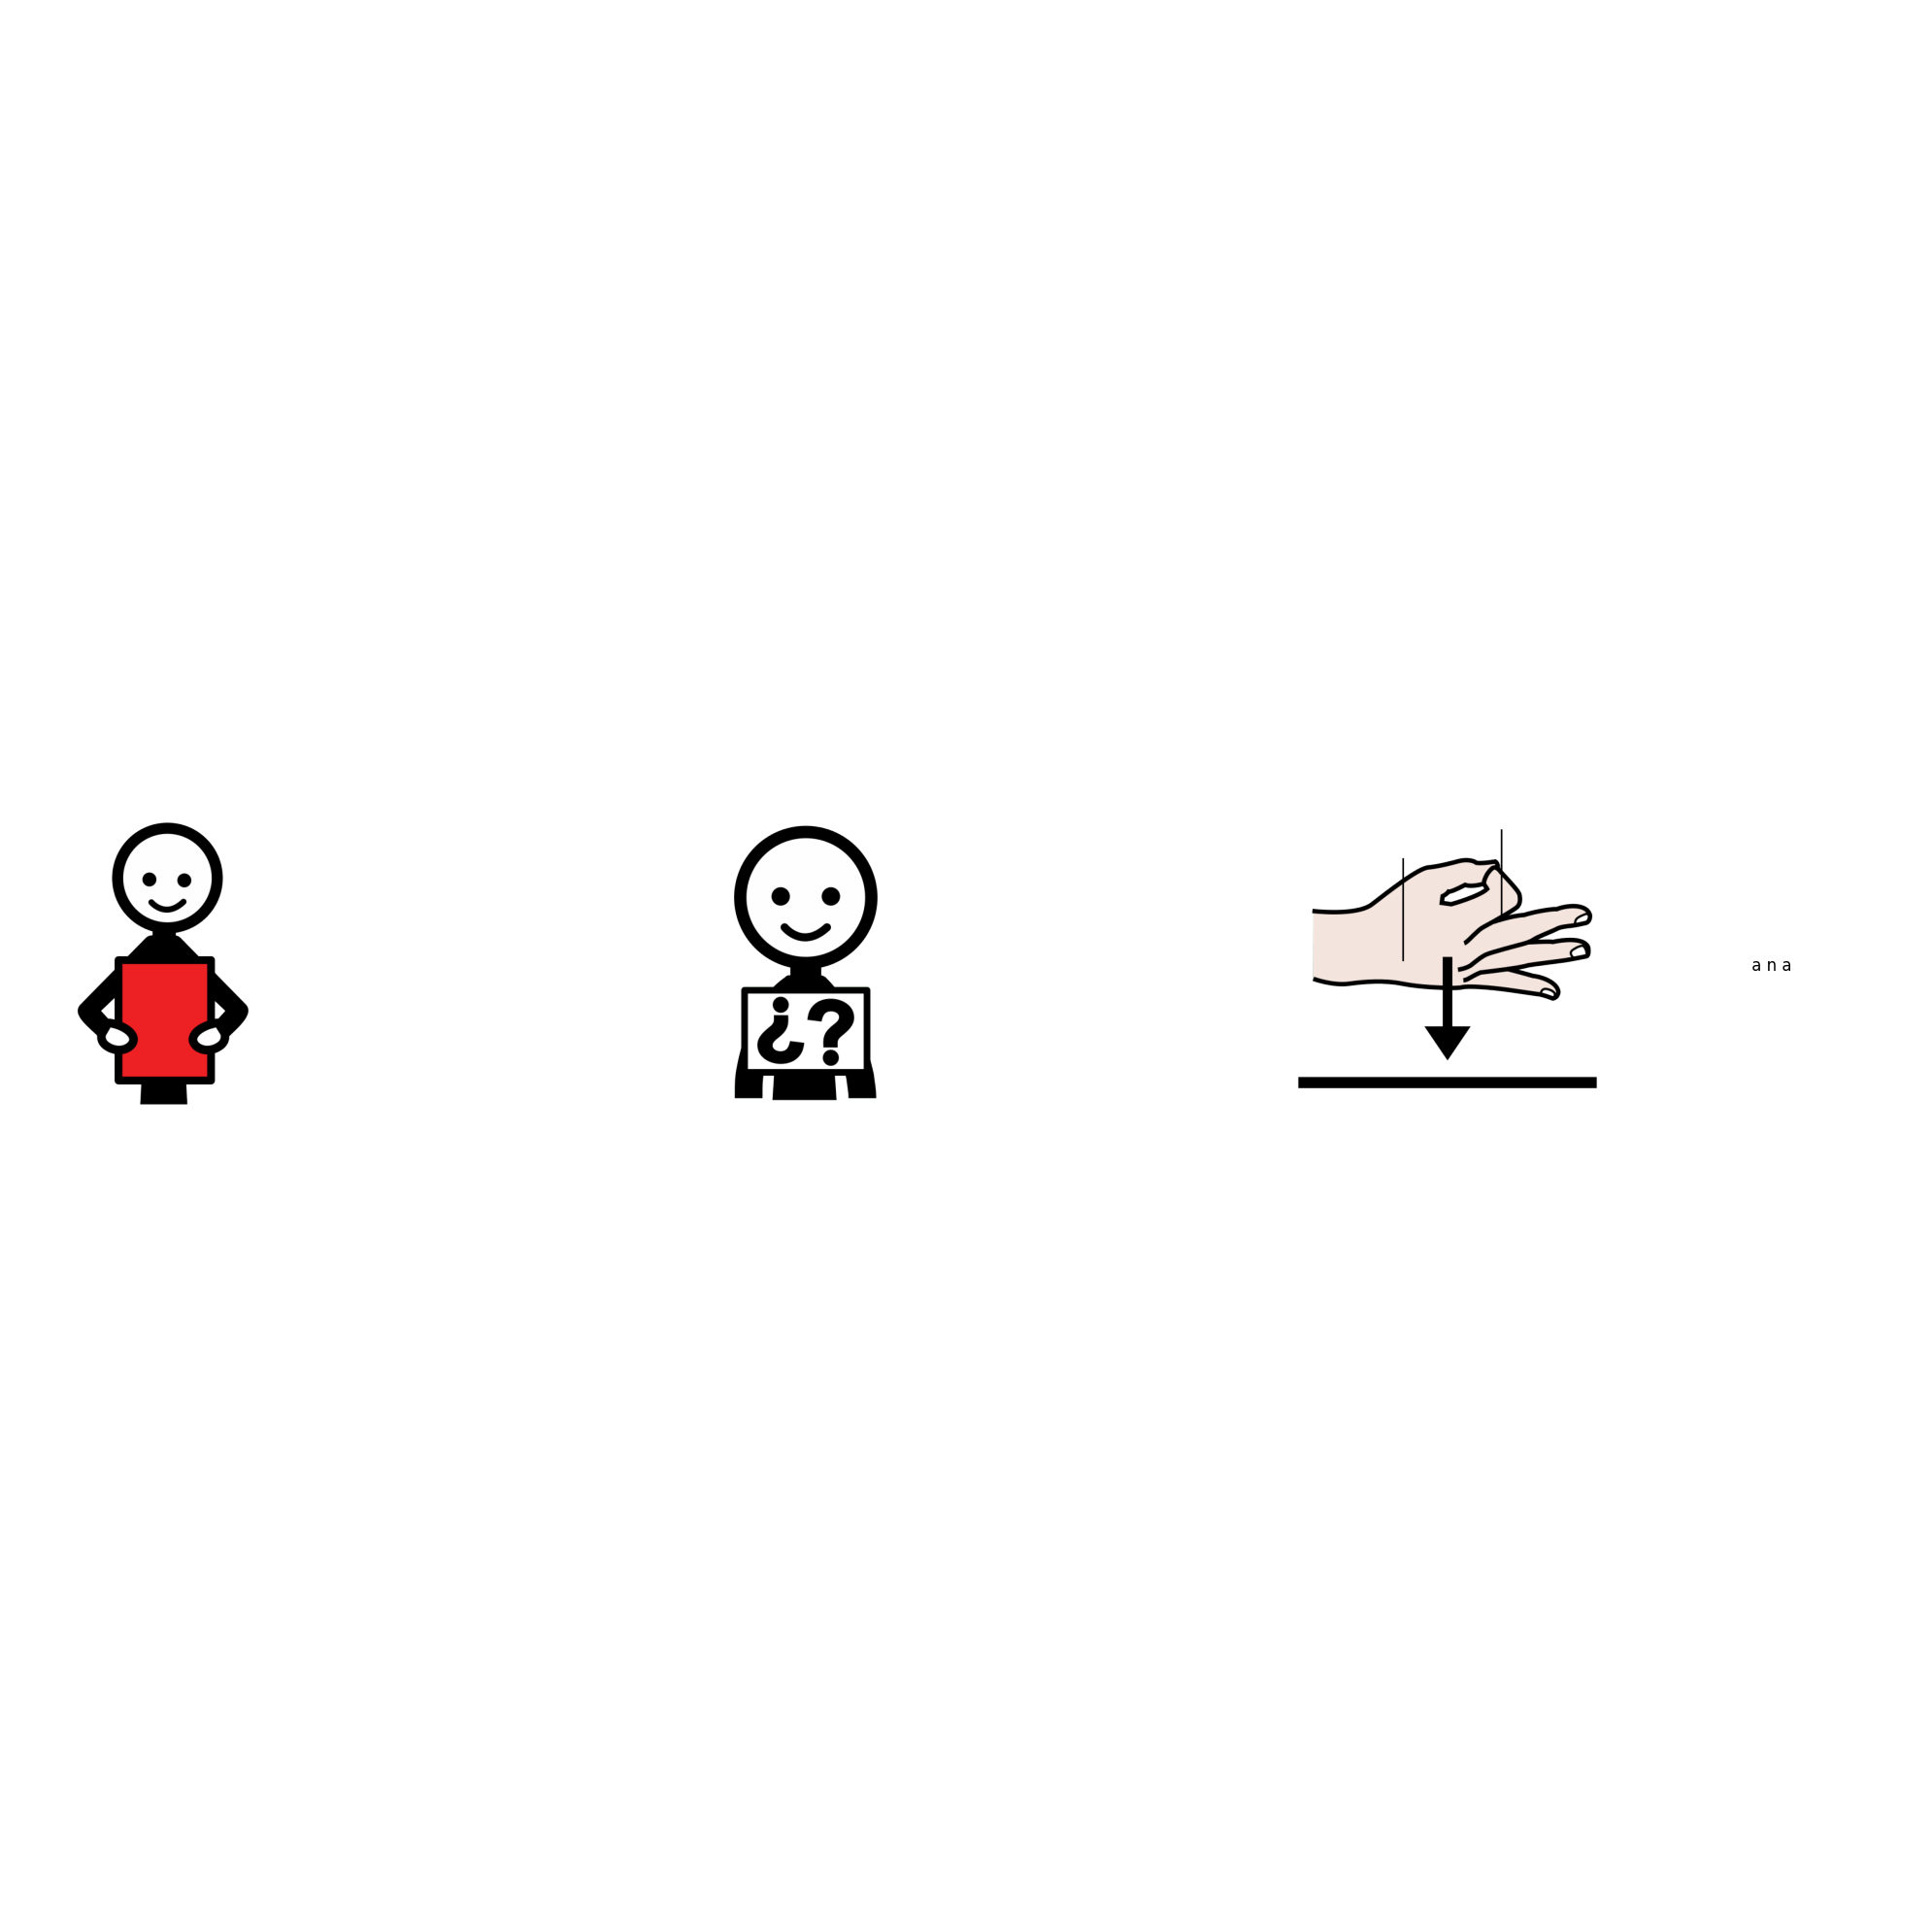

validado
#12264#mi# #7061#nombre# #32845#niña#
3
traduccion modelo validado: Mi nombre es Ana


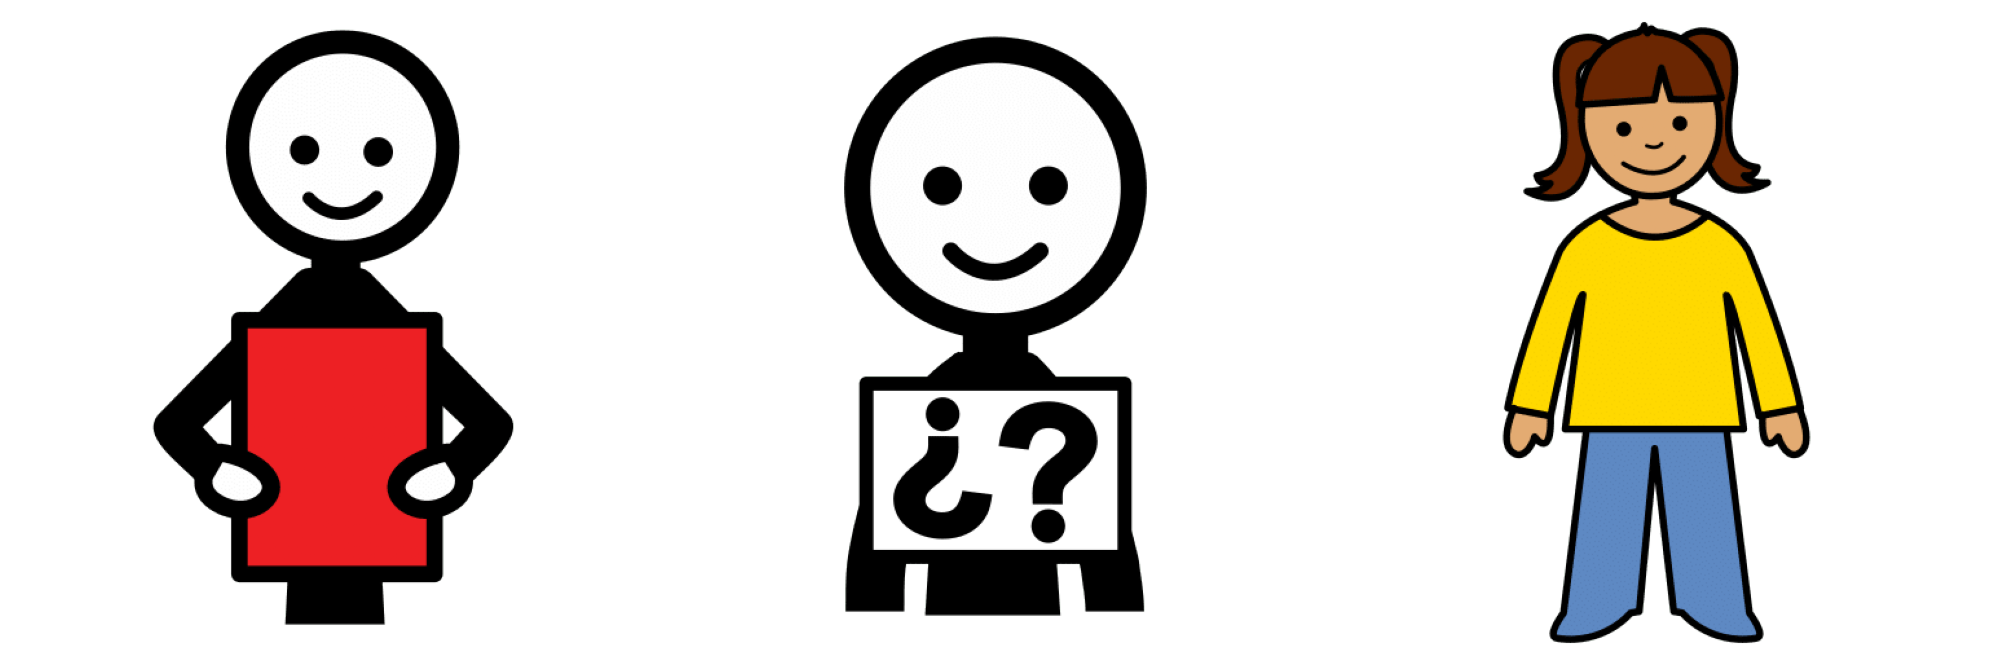

In [72]:
tokens = obtener_tokens(oracion_traducida) 

rutas_imagenes = []
for elemento in tokens:
  rutas_imagenes.append(obtener_ruta(elemento))

print(f"oracion original: {dataset_valid[idx].get('oracion')}")
print(f"traduccion modelo base: {dataset_valid[idx].get('traduccion')}")
print(f"traduccion modelo T5: {oracion_traducida}")
imprimir_imagenes(rutas_imagenes)


In [131]:
dataset_valid01 = load_dataset(
    'json',
    data_files='pruebasUnitarias.json',
    split='train'
)
encoded_val_user = dataset_valid01.map(preprocess_function, batched=True)

predict01=trainer.predict(encoded_val_user,max_length=max_target_length)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [132]:
idx00 = 0
prediccionT5 = predict01.predictions[idx00]
prediccionT5 = np.where(prediccionT5 != -100, prediccionT5, tokenizer.pad_token_id)

traducciont5 = tokenizer.batch_decode(
        prediccionT5,
        skip_special_tokens=True
    )
print(traducciont5)
oracion_traducida_t5 = " ".join(traducciont5).strip()

oracion_traducida_t5

['', '#2617#yo#', '', '#2617#me#', '', '#4687#llamar#', '', '#7238#José#', '', '', '', '', '', '', '', '', '', '', '', '']


'#2617#yo#  #2617#me#  #4687#llamar#  #7238#José#'

8
5
oracion: Indicó los materiales a utilizar
traducción validada: #6612#indicar#past# #34153#material escolar# #3021#a# #15485#utilizar#
traducción modelo T5: #8579#explicar#  #7033#los# materiales  #3021#a#  #15485#utilizar#


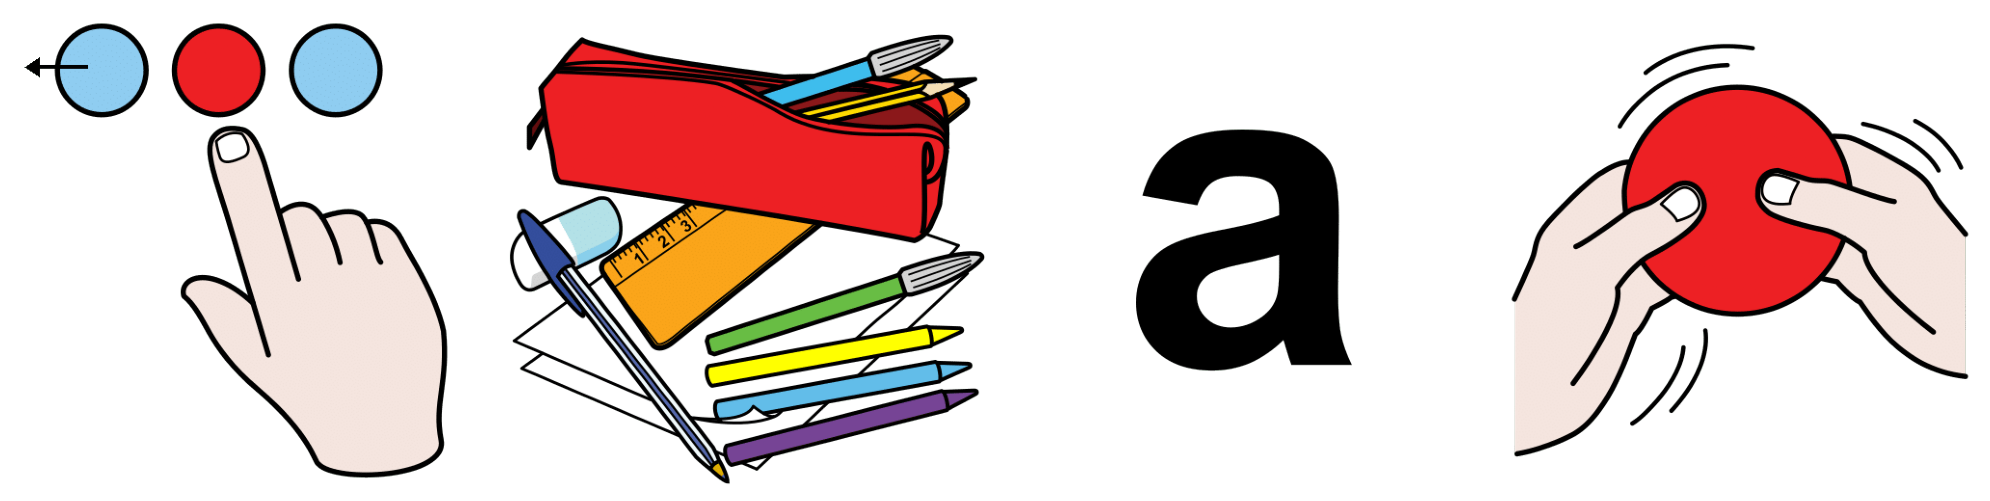

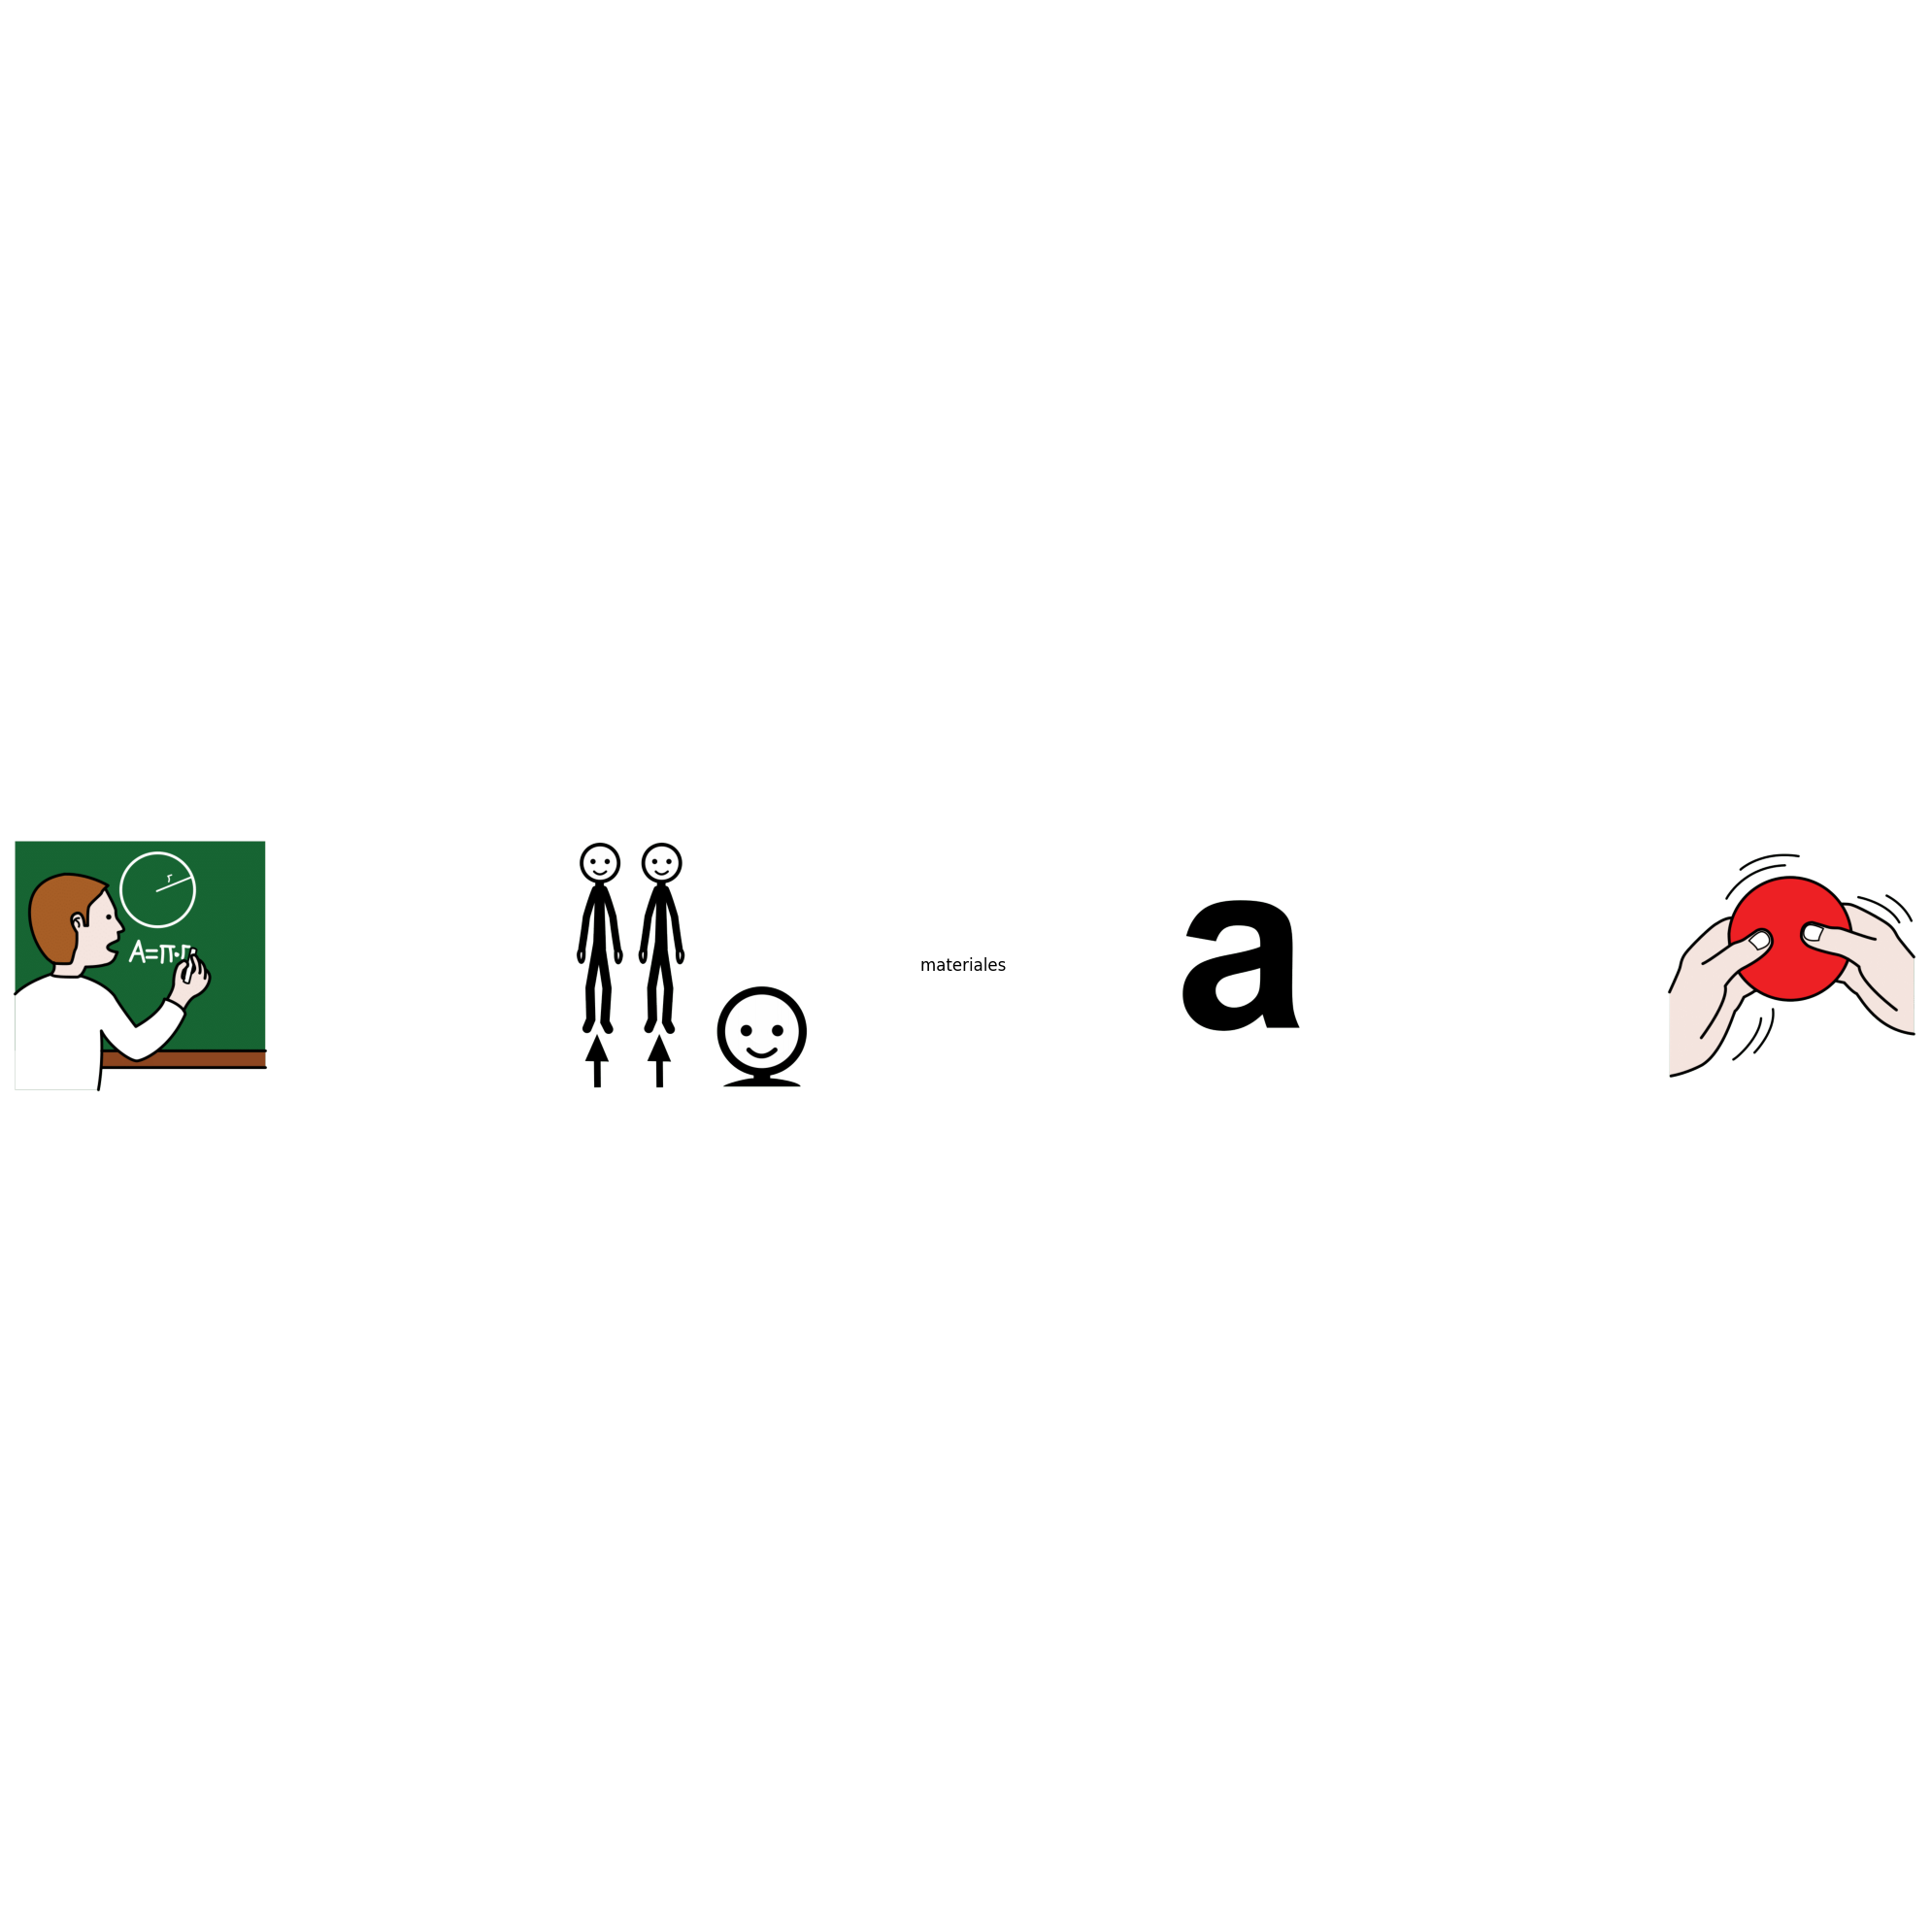

In [129]:
tokenst5 = obtener_tokens(oracion_traducida_t5) 

rutas_imagenes01 = []
for elemento in tokenst5:
  rutas_imagenes01.append(obtener_ruta(elemento))


rutas_imagenes02 = []
tokensValUsuario = obtener_tokens(dataset_valid01[idx00].get('traduccion')) 

for elemento in tokensValUsuario:
  rutas_imagenes02.append(obtener_ruta(elemento))
    
print(f"oracion: {dataset_valid01[idx00].get('oracion')}")
print(f"traducción validada: {dataset_valid01[idx00].get('traduccion')}")
print(f"traducción modelo T5: {oracion_traducida_t5}")

imprimir_imagenes(rutas_imagenes02)
imprimir_imagenes(rutas_imagenes01)



Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

['', '#8579#explicar#', '', '#7033#los#', 'materiales', '', '#3021#a#', '', '#15485#utilizar#', '', '', '', '', '', '', '', '', '', '', '']
8
oracion: Indicó los materiales a utilizar
traducción modelo T5: #8579#explicar#  #7033#los# materiales  #3021#a#  #15485#utilizar#


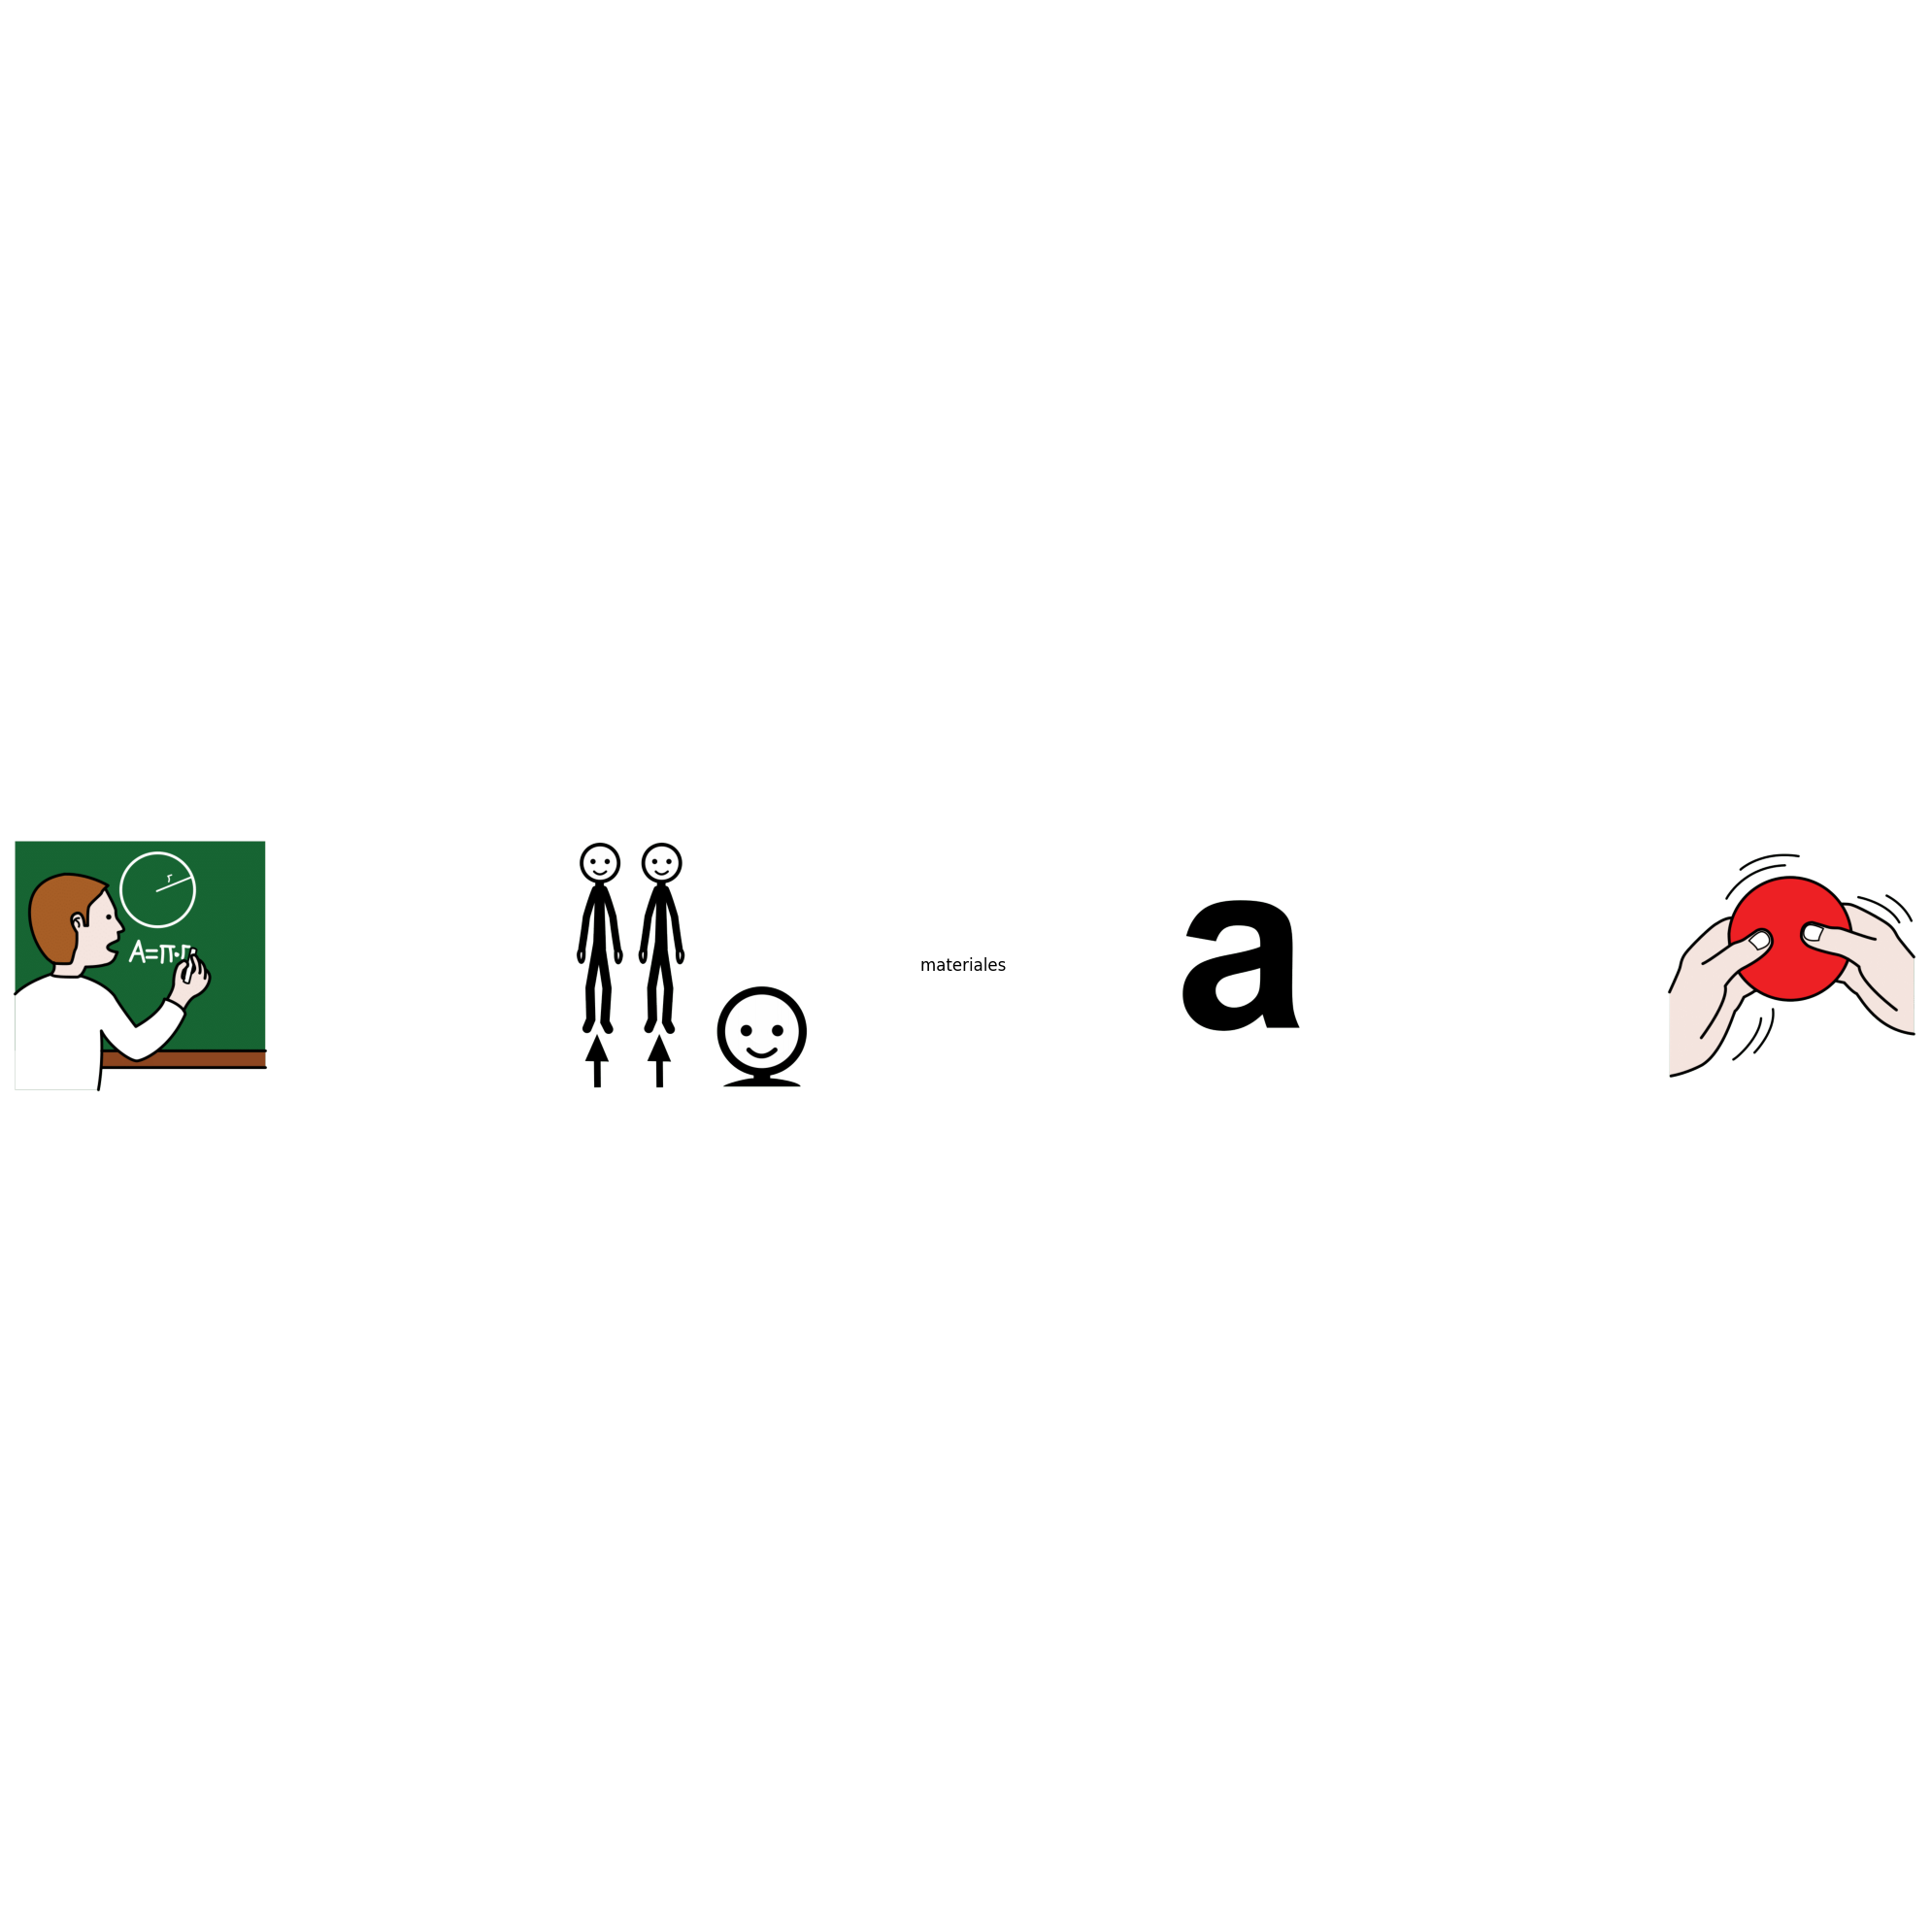

In [149]:
dataset_valid02 = load_dataset(
    'json',
    data_files='pruebasUnitarias.json',
    split='train'
)
encoded_val_user = dataset_valid02.map(preprocess_function, batched=True)

predict02=trainer.predict(encoded_val_user,max_length=max_target_length)

idx00 = 0
prediccionT501 = predict02.predictions[idx00]
prediccionT501 = np.where(prediccionT501 != -100, prediccionT501, tokenizer.pad_token_id)

traducciont501 = tokenizer.batch_decode(
        prediccionT501,
        skip_special_tokens=True
    )
print(traducciont501)
oracion_traducida_t501 = " ".join(traducciont501).strip()

tokenst501 = obtener_tokens(oracion_traducida_t501) 

rutas_imagenes03 = []
for elemento in tokenst501:
  rutas_imagenes03.append(obtener_ruta(elemento))

print(f"oracion: {dataset_valid02[idx00].get('oracion')}")
print(f"traducción modelo T5: {oracion_traducida_t501}")

imprimir_imagenes(rutas_imagenes03)